Khám phá dữ liệu

In [2]:

# connect Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ML/gk'


Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/gk


In [8]:
import pandas as pd
import pylab
pylab.style.use('seaborn-pastel')
import matplotlib.pyplot as plt
%matplotlib inline

#Feature Selection Imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect

#Outlier Handling Imports
from scipy.stats.mstats import winsorize

#Normalization & Scaler Imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.decomposition import PCA

#Sampling Imports
from sklearn.model_selection import KFold

data = pd.read_csv("Wholesale_customers_data.csv")
# Hiển thị 5 dòng dữ liệu đầu tiên
print(data.head(5))

# Hiển thị thông tin về các cột
print(data.info())

# Thống kê mô tả của dữ liệu
print(data.describe())

<ipython-input-8-bf6cc4e012c9>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  pylab.style.use('seaborn-pastel')


   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen  

Bộ dữ liệu gồm 440 mẫu và 8 đặc trưng

Trong đó, tât cả các đặc trưng định lượng liên tục (kiểu dữ liệu int64)

Tất cả các đặc trưng đều không có giá trị rỗng (non-null), do đó không cần phải xử lý khoản này về sau.

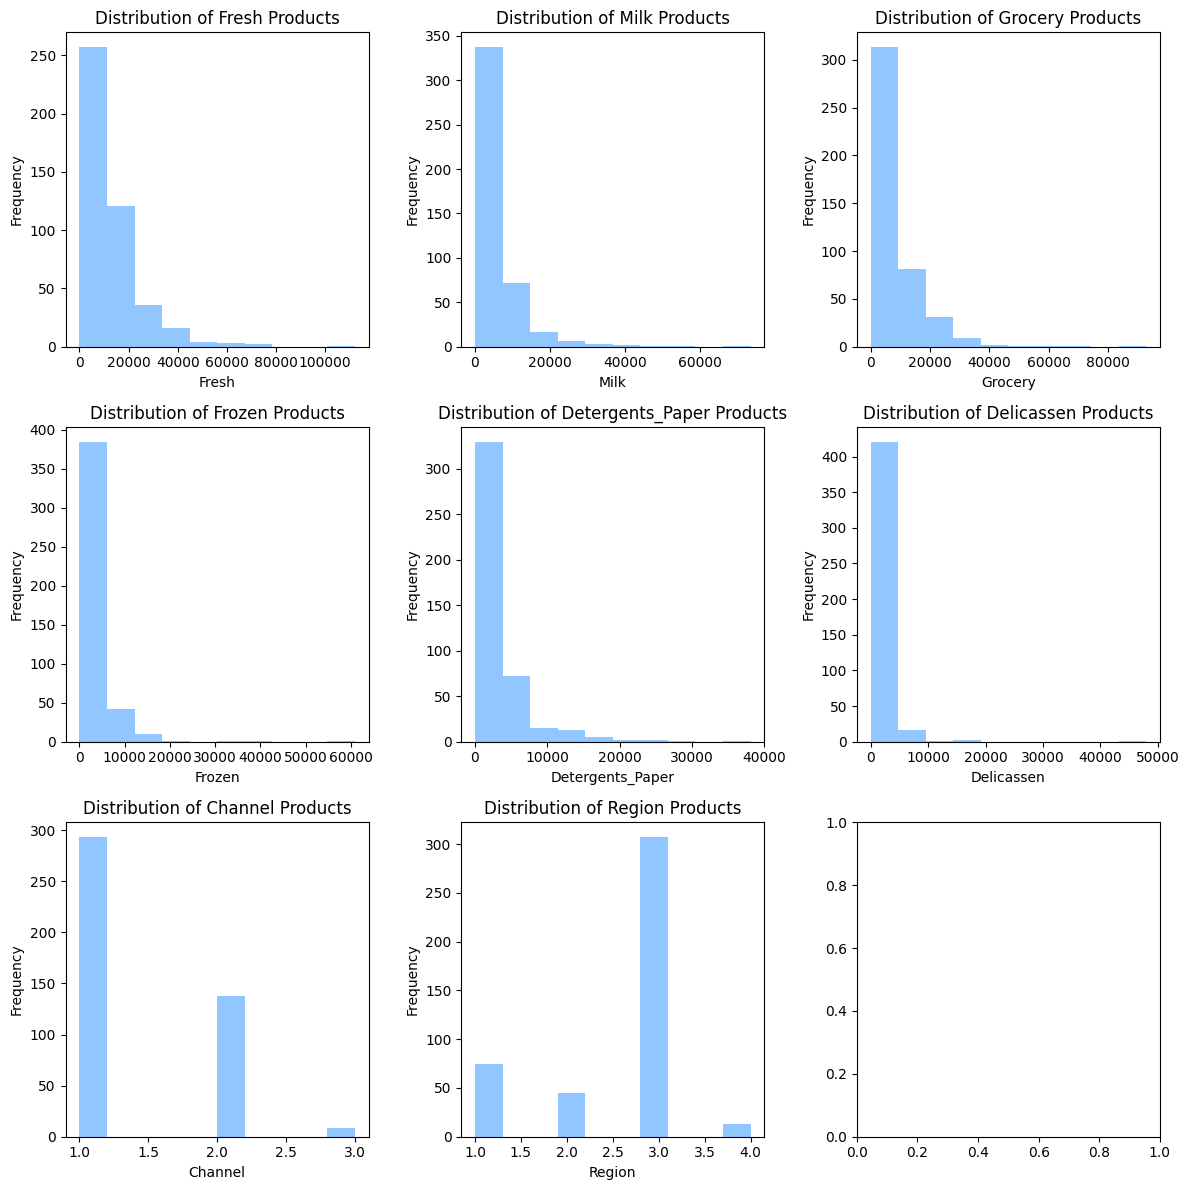

In [21]:
# Biểu đồ histogram của 8 đặc trưng định lượng
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

attributes = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen', 'Channel', 'Region']

num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    if i < len(attributes):
        ax.hist(data[attributes[i]], bins=10)
        ax.set_xlabel(attributes[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {attributes[i]} Products')
# Căn chỉnh khoảng cách giữa các biểu đồ       
plt.tight_layout()
plt.show()

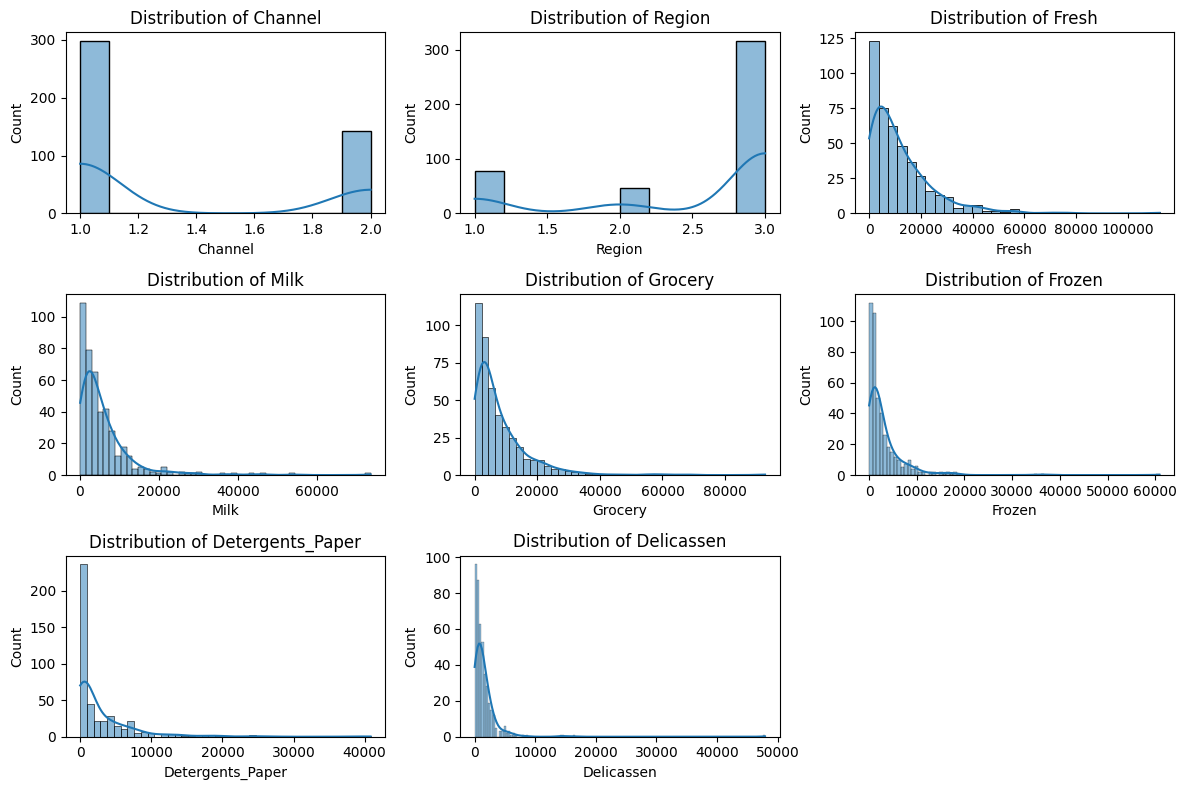

In [ ]:
# Vẽ histogram cho từng đặc trưng
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

for i, feature in enumerate(data.columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

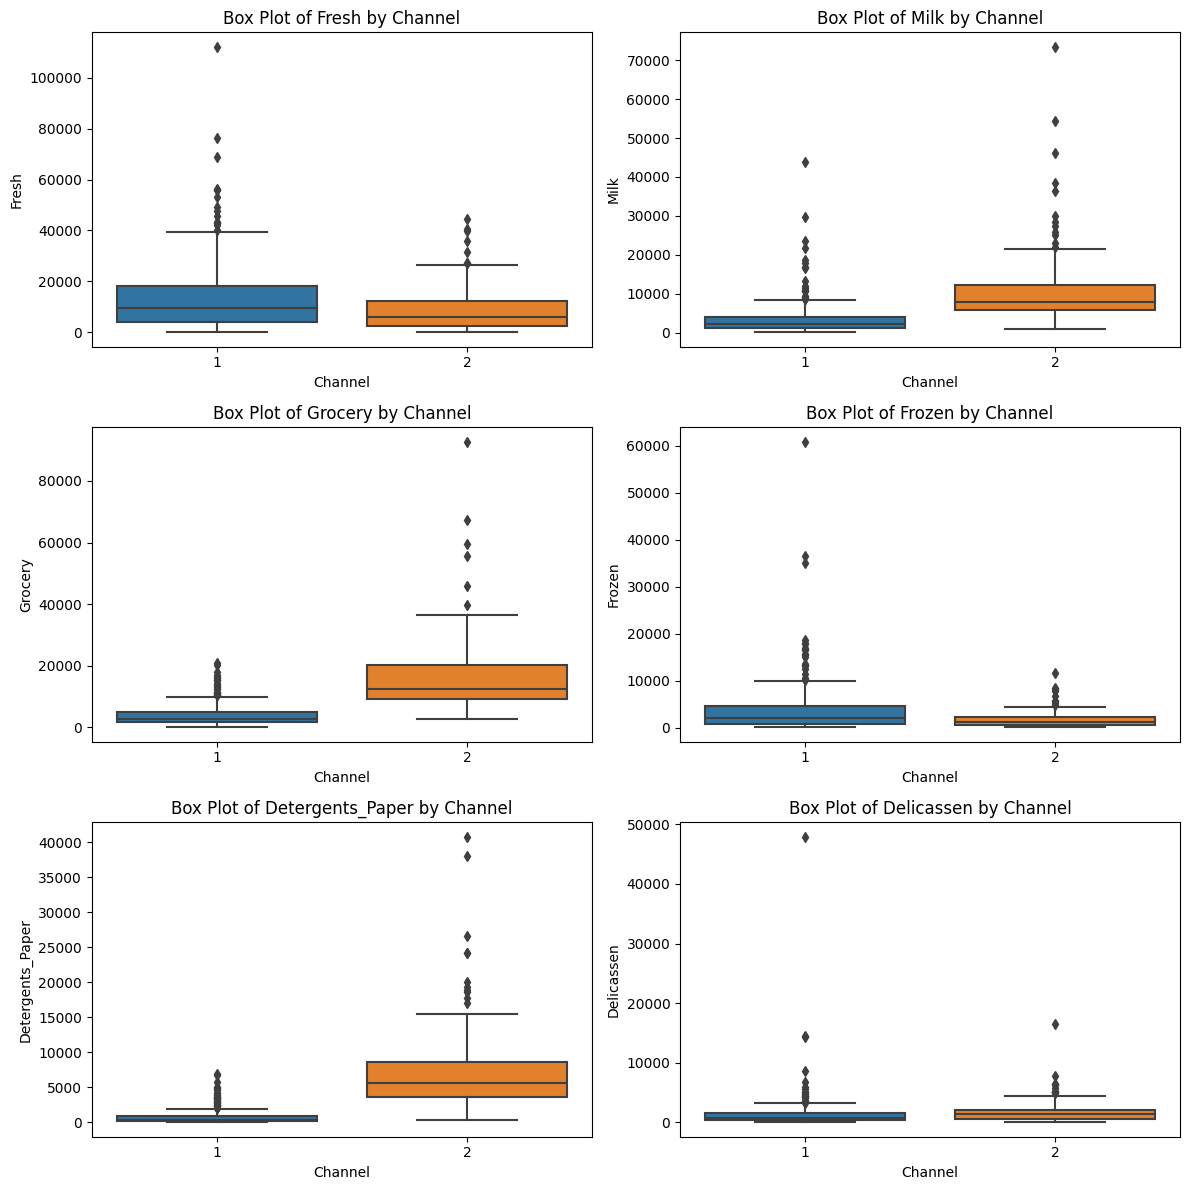

In [ ]:
# Biểu đồ hộp thể hiện quan hệ giữagiữa thuộc  và biến phân lớp
# Danh sách các đặc trưng định lượng
numeric_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Biến phân lớp
class_variable = 'Channel'

# Thiết lập kích thước và định dạng biểu đồ
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Vẽ biểu đồ hộp cho từng đặc trưng
for i, feature in enumerate(numeric_features):
    sns.boxplot(x=class_variable, y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature} by {class_variable}')

# Xóa các trục trống
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

# Hiển thị biểu đồ hộp
plt.tight_layout()
plt.show()

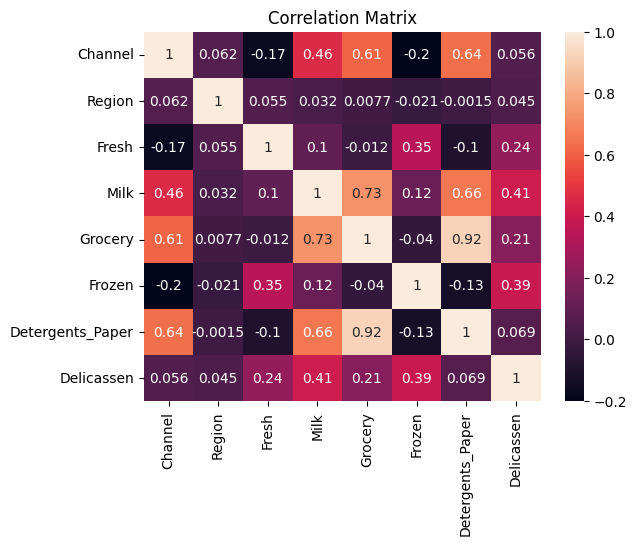

In [ ]:
# Biểu đồ tương quan (Heatmap):


correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

tiền xủ lý dữ liệu

In [ ]:
# xác định các giá trị thiếu trong tập dữ liệu
missing_values = data.isnull()
# đếm số lượng giá trị thiếu trong mỗi thuộc tính.
missing_count = data.isnull().sum()
# Xóa mẫu dữ liệu chứa giá trị thiếu
data_cleaned = data.dropna()

# Điền giá trị thiếu bằng giá trị trung bình của thuộc tính
data_filled = data.fillna(data.mean())
# Kiểm tra lại:
data_cleaned.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

không có dữ liệu bị thiếu

In [5]:
#Đếm các giá trị và danh mục duy nhất theo đặc trưng cho Cột Kênh & Khu vực
column_list = ['Channel','Region']
#print(column_list)
for col in column_list:
    print('Feature: {:<9s} | Unique-Count: {:<3} | Categories: {:}'.format(col,data[col].nunique(),data[col].unique()))

Feature: Channel   | Unique-Count: 2   | Categories: [2 1]
Feature: Region    | Unique-Count: 3   | Categories: [3 1 2]


In [10]:
#Vì tập dữ liệu không có bất kỳ giá trị null nào nên áp dụng các giá trị null để giải thích tầm quan trọng của việc tiền xử lý xử lý giá trị null
#Chèn 3% giá trị của mỗi cột là null... [Tổng hợp]
import random
ix = [(row, col) for row in range(data.shape[0]) for col in range(data.shape[1])]
for row, col in random.sample(ix, int(round(.03*len(ix)))):
    data.iat[row, col] = None

In [12]:
#Kiểm tra giá trị null sau khi chèn null tổng hợp
data.isnull().sum().sort_values(ascending=False)

Detergents_Paper    20
Frozen              19
Region              13
Fresh               13
Delicassen          12
Grocery             11
Channel              9
Milk                 9
dtype: int64

In [13]:
#Chỉ định danh mục duy nhất cho khu vực & tính năng Kênh là '3' & '4' theo cách tiếp nhận. Để xử lý null
data['Channel'] = data['Channel'].fillna(3)
data['Region'] = data['Region'].fillna(4)
data.isnull().sum().sort_values(ascending=False)

Detergents_Paper    20
Frozen              19
Fresh               13
Delicassen          12
Grocery             11
Milk                 9
Channel              0
Region               0
dtype: int64

In [14]:
# Đối với phần còn lại của giá trị null, hãy kiểm tra thông tin chi tiết về dữ liệu
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,427.000000,431.000000,429.000000,421.000000,420.000000,428.000000
mean,1.354545,2.586364,12053.374707,5829.816705,8030.223776,3024.902613,2824.476190,1522.294393
std,0.519968,0.802499,12736.967646,7431.153763,9575.020129,4848.437680,4467.228472,2847.411911
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3100.000000,1579.500000,2174.000000,688.000000,265.500000,408.250000
50%,1.000000,3.000000,8565.000000,3634.000000,4897.000000,1535.000000,816.500000,962.500000
75%,2.000000,3.000000,16934.500000,7196.500000,10685.000000,3527.000000,3971.500000,1820.250000
max,3.000000,4.000000,112151.000000,73498.000000,92780.000000,60869.000000,38102.000000,47943.000000


In [16]:
#Median và Mean bằng cách nhóm kênh & khu vực
df_MVal = data.drop(['Channel','Region'], axis=1)
data.groupby(['Channel', 'Region']).agg(['median','mean']).round(1)

Fresh              Milk           Grocery           Frozen  \
                 median     mean   median     mean   median     mean  median   
Channel Region                                                                 
1.0     1.0      9039.0  13405.0   2204.0   3732.0   2488.0   3845.6  2077.0   
        2.0     10203.5  12166.2   1610.0   2356.3   3389.0   4585.9  2879.5   
        3.0      9612.0  13555.9   2306.0   3437.5   2625.5   3874.2  1960.0   
        4.0      1670.0   3421.0   1979.0   2986.6   2543.0   3039.0   821.5   
2.0     1.0      2926.0   5500.6   7778.5  10500.1  15325.0  17761.9  1522.0   
        2.0      5283.0   6173.9   6851.5   9322.7  13018.0  16633.9   902.0   
        3.0      7579.0  10176.9   8019.0  10624.8  12232.0  16286.8  1137.0   
        4.0     12126.0  12787.0   9656.0  18140.4  10204.0  15294.3   987.0   
3.0     1.0      1956.5   1956.5  11238.0  11238.0  19567.0  19567.0  1164.5   
        3.0      9670.0  22274.0   7027.0   8190.1  10471.0   9460.4   541.0   

                       Detergents_Paper         Delicassen          
                  mean           median    mean     median    mean  
Channel Region                                                      
1.0     1.0     3277.3            409.0   843.3      703.5  1157.7  
        2.0     6089.5            351.0   501.4      898.0  1127.5  
        3.0     3538.6            380.0   767.2      833.0  1503.9  
        4.0      973.0            367.5   817.3      458.5   520.2  
2.0     1.0     2625.6           5957.0  7708.1     1414.0  1956.5  
        2.0     1555.4           6236.0  8592.8     1037.0  1227.7  
        3.0     1579.1           5131.0  6576.9     1438.0  1927.9  
        4.0     1482.7           4111.0  8016.7     1338.0  1263.0  
3.0     1.0     1164.5           7546.5  7546.5     1549.0  1549.0  
        3.0     3782.4           4196.0  3452.9      412.0  1703.9

In [18]:
#Như ở trên, chúng ta có thể dễ dàng hiểu việc điền theo giá trị trung bình là tối ưu vì việc nhóm theo Kênh & Khu vực sẽ không hữu ích ở đây.
#Sự khác biệt lớn giữa trung vị và trung bình
data.fillna(data.mean(), inplace=True)
data.isnull().sum().sort_values(ascending=False)

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [20]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
#Hãy mã hóa và chọn các tính năng tốt nhất
label_encoder = LabelEncoder()
df_1 = data.apply(label_encoder.fit_transform)
# X_feature = data.drop('Channel', axis=1)
# Y_label = data['Channel']
X = df_1.drop('Channel', axis=1)
Y = df_1['Channel']


#trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=15)
trans = GenericUnivariateSelect(score_func = mutual_info_classif, mode='percentile', param = 70)
trans_feat = trans.fit_transform(X, Y)
columns_ = df_1.iloc[:, 1:].columns[trans.get_support()].values

# X_feature as tranformed top feature variables
X_feature = pd.DataFrame(trans_feat, columns=columns_)

# Y_label with only target variable
Y_label = Y

X_feature.columns

Index(['Region', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper'], dtype='object')

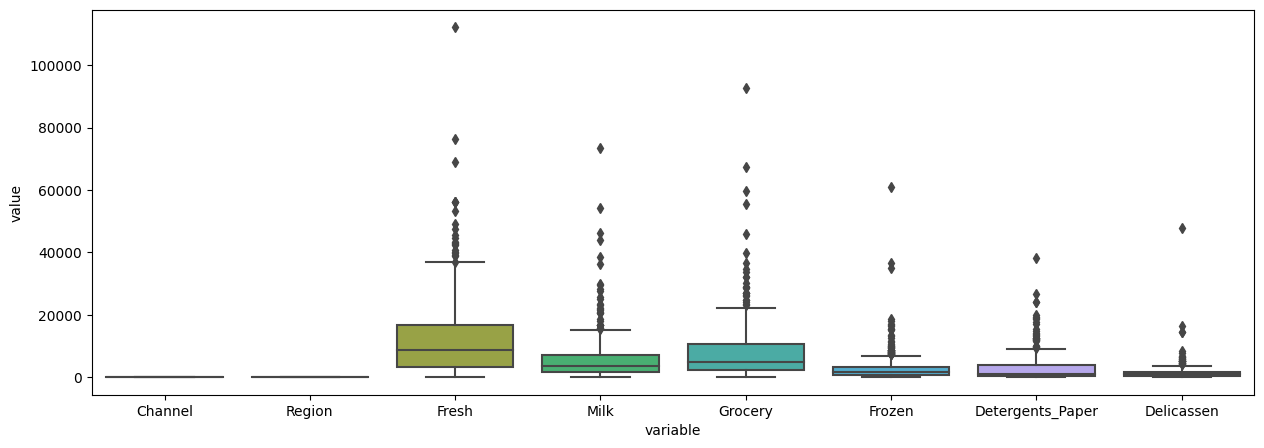

In [25]:
#Hiển thị độ phân tán (độ lệch chuẩn và IQR) của các tính năng
plt.figure(figsize=(15,5))
sns.boxplot(x='variable', y='value', data=data.melt())
plt.show()

In [32]:
#sử dụng 5 lần chia dữ liệu.
skf = KFold(n_splits=5)
for train_index,test_index in skf.split(X_feature, Y_label):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_feature.loc[train_index],X_feature.loc[test_index]
    y_train, y_test = Y_label.loc[train_index],Y_label.loc[test_index]

# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X_feature, Y_label, test_size = 0.3, random_state = 0)

print('{:<15} {:<15} {:<15}'.format('DataSet','Features','Label'))
print('{:<15} {:<15} {:<15}'.format('Train',X_train.shape[0],Y_train.shape[0]))
print('{:<15} {:<15} {:<15}'.format('Test',X_test.shape[0],Y_test.shape[0]))

DataSet         Features        Label          
Train           352             352            
Test            88              88             


XÂY DỰNG CÁC MÔ HÌNH

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
# Bước 1: Chuẩn bị dữ liệu
 # lấy dữ liệu
data = pd.read_csv("Wholesale_customers_data.csv")

# # Bước 2: Tiền xử lý dữ liệu
# # Loại bỏ cột không cần thiết (cột 'Region')
# data = data.drop('Region', axis=1)

# # Chuyển đổi tên cột nhãn thành "Label"
# data = data.rename(columns={'Channel': 'Label'})
# label_encoder = LabelEncoder()
# data['Label'] = label_encoder.fit_transform(data['Label'])

# # Tiến hành scaling
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)
# # Chuyển đổi nhãn về dạng số nguyên (nếu cần)
# # data_scaled[:, -1] = data_scaled[:, -1].astype(int)


# # Bước 3: Chia dữ liệu
# X = scaled_data[:, :-1]  # Đặc trưng
# y = scaled_data[:, -1]   # Nhãn
X_train, X_test, y_train, y_test = train_test_split(X_feature, Y_label, test_size = 0.3, random_state = 0)
# # Chuyển đổi nhãn về dạng số nguyên (nếu cần)
# y_train = y_train.astype(int)
# y_test = y_test.astype(int)

# Bước 4: Xây dựng và đánh giá mô hình
# Neural Network
nn_model = MLPClassifier()
nn_model.fit(X_train,y_train)
nn_predictions = nn_model.predict(X_test)
nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_precision = precision_score(y_test, nn_predictions,average='macro')
nn_recall = recall_score(y_test, nn_predictions,average='macro')
nn_f1score = f1_score(y_test, nn_predictions,average='macro')

# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions,average='macro')
svm_recall = recall_score(y_test, svm_predictions,average='macro')
svm_f1score = f1_score(y_test, svm_predictions,average='macro')

# kNN
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_precision = precision_score(y_test, knn_predictions,average='macro')
knn_recall = recall_score(y_test, knn_predictions,average='macro')
knn_f1score = f1_score(y_test, knn_predictions,average='macro')

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions,average='macro')
nb_recall = recall_score(y_test, nb_predictions,average='macro')
nb_f1score = f1_score(y_test, nb_predictions,average='macro')

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions,average='macro')
rf_recall = recall_score(y_test, rf_predictions,average='macro')
rf_f1score = f1_score(y_test, rf_predictions,average='macro')

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions,average='macro')
dt_recall = recall_score(y_test, dt_predictions,average='macro')
dt_f1score = f1_score(y_test, dt_predictions,average='macro')

# In kết quả
print("Neural Network:")
print("Accuracy:", nn_accuracy)
print("Precision:", nn_precision)
print("Recall:", nn_recall)
print("F1-score:", nn_f1score)


print("SVM:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1-score:", svm_f1score)


print("kNN:")
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1-score:", knn_f1score)

print("Naive Bayes:")
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1-score:", nb_f1score)

print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1score)

print("Decision Tree:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1score)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Network:
Accuracy: 0.8409090909090909
Precision: 0.5719057665260197
Recall: 0.5741532976827094
F1-score: 0.5721102863202545
SVM:
Accuracy: 0.8712121212121212
Precision: 0.5768115942028985
Recall: 0.575222816399287
F1-score: 0.5749260156039817
kNN:
Accuracy: 0.8863636363636364
Precision: 0.5887681159420289
Recall: 0.5867201426024956
F1-score: 0.5866290018832392
Naive Bayes:
Accuracy: 0.8863636363636364
Precision: 0.5815638692281766
Recall: 0.5976827094474153
F1-score: 0.5894736842105263
Random Forest:
Accuracy: 0.8636363636363636
Precision: 0.5723738626964433
Recall: 0.5676470588235294
F1-score: 0.5684310274807093
Decision Tree:
Accuracy: 0.8181818181818182
Precision: 0.6512113617376775
Recall: 0.6366904337492573
F1-score: 0.6423380142892338


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


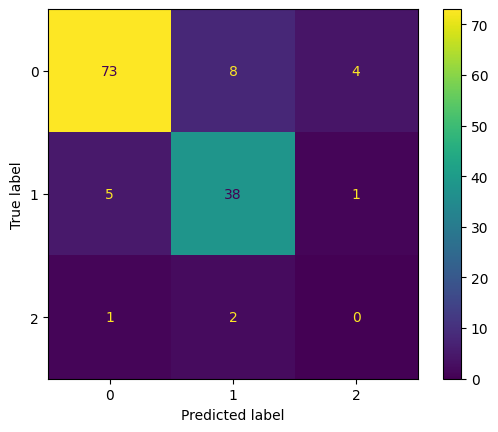

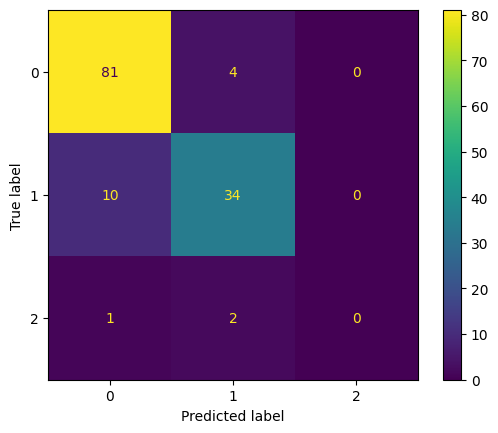

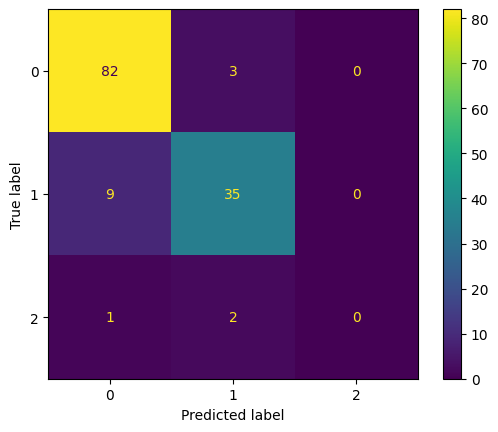

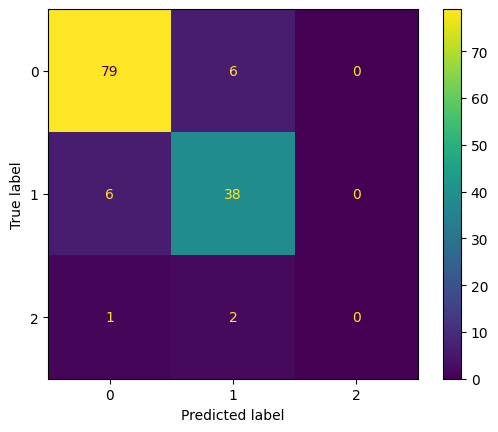

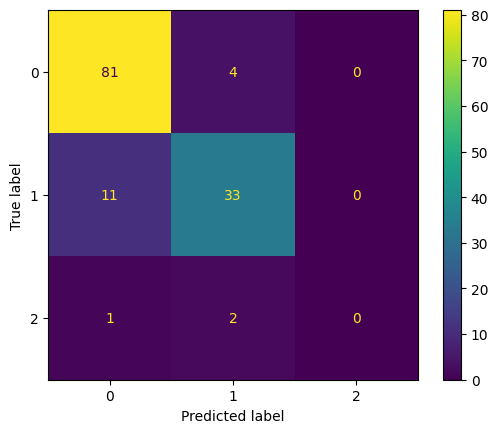

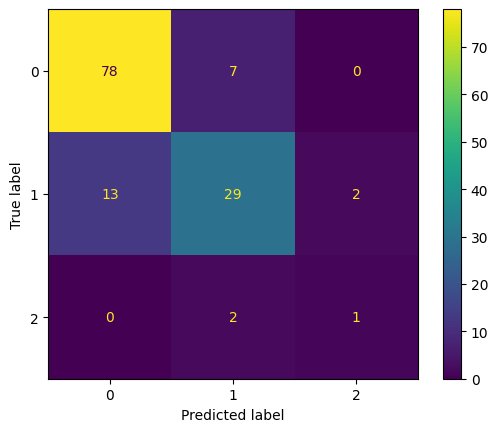

In [37]:
ConfusionMatrixDisplay.from_estimator(nn_model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test)


In [38]:
# So sánh hiệu suất của các mô hình
models = ['Neural Network', 'SVM', 'kNN', 'Naive Bayes', 'Random Forest', 'Decision Tree']
accuracy_scores = [nn_accuracy, svm_accuracy, knn_accuracy, nb_accuracy, rf_accuracy, dt_accuracy]
precision_scores = [nn_precision, svm_precision, knn_precision, nb_precision, rf_precision, dt_precision]
recall_scores = [nn_recall, svm_recall, knn_recall, nb_recall, rf_recall, dt_recall]
f1_scores = [nn_f1score, svm_f1score, knn_f1score, nb_f1score, rf_f1score, dt_f1score]

results_df = pd.DataFrame({'Model': models,
                           'Accuracy': accuracy_scores,
                           'Precision': precision_scores,
                           'Recall': recall_scores,
                           'F1-score': f1_scores})

print(results_df)

            Model  Accuracy  Precision    Recall  F1-score
0  Neural Network  0.840909   0.571906  0.574153  0.572110
1             SVM  0.871212   0.576812  0.575223  0.574926
2             kNN  0.886364   0.588768  0.586720  0.586629
3     Naive Bayes  0.886364   0.581564  0.597683  0.589474
4   Random Forest  0.863636   0.572374  0.567647  0.568431
5   Decision Tree  0.818182   0.651211  0.636690  0.642338


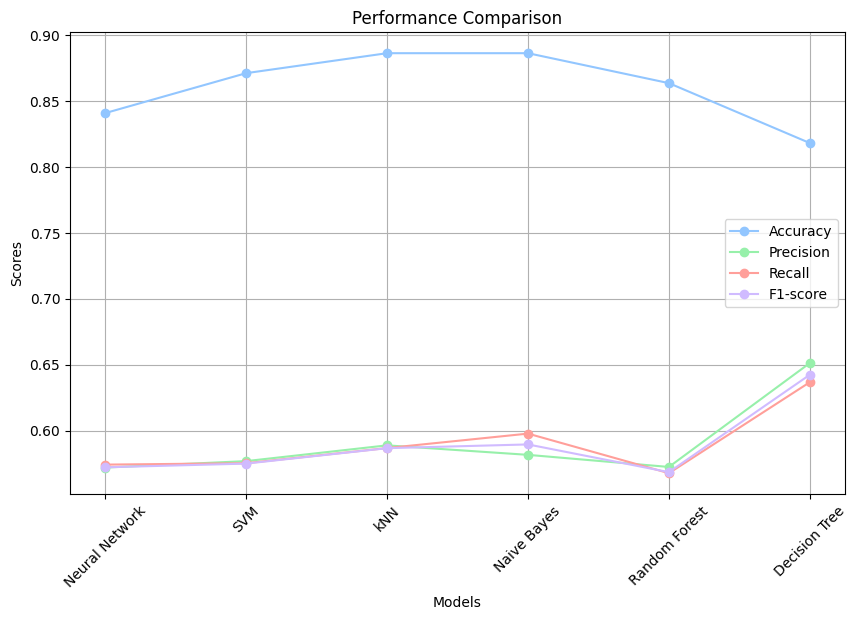

In [39]:
# Trực quan hóa kết quả đánh giá
plt.figure(figsize=(10, 6))

plt.plot(models, accuracy_scores, marker='o', label='Accuracy')
plt.plot(models, precision_scores, marker='o', label='Precision')
plt.plot(models, recall_scores, marker='o', label='Recall')
plt.plot(models, f1_scores, marker='o', label='F1-score')

plt.title('Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

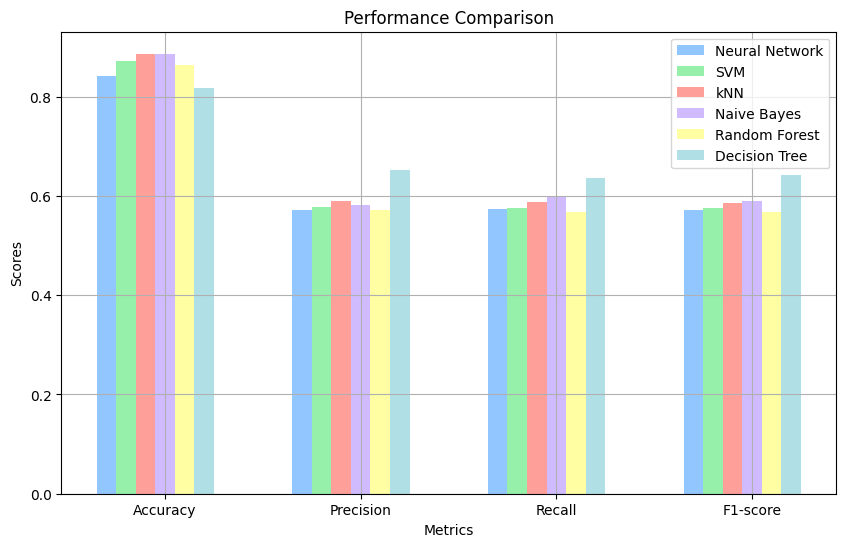

In [41]:
# Các độ đo đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Giá trị đánh giá của mỗi mô hình
nn_scores = [nn_accuracy, nn_precision, nn_recall, nn_f1score]
svm_scores = [svm_accuracy, svm_precision, svm_recall, svm_f1score]
knn_scores = [knn_accuracy, knn_precision, knn_recall, knn_f1score]
nb_scores = [nb_accuracy, nb_precision, nb_recall, nb_f1score]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1score]
dt_scores = [dt_accuracy, dt_precision, dt_recall, dt_f1score]

# Chỉ số x cho các mô hình
x = np.arange(len(metrics))

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

plt.bar(x-0.3, nn_scores, width=0.1, align='center', label='Neural Network')
plt.bar(x-0.2, svm_scores, width=0.1, align='center', label='SVM')
plt.bar(x-0.1, knn_scores, width=0.1, align='center', label='kNN')
plt.bar(x, nb_scores, width=0.1, align='center', label='Naive Bayes')
plt.bar(x+0.1, rf_scores, width=0.1, align='center', label='Random Forest')
plt.bar(x+0.2, dt_scores, width=0.1, align='center', label='Decision Tree')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True)
plt.show()

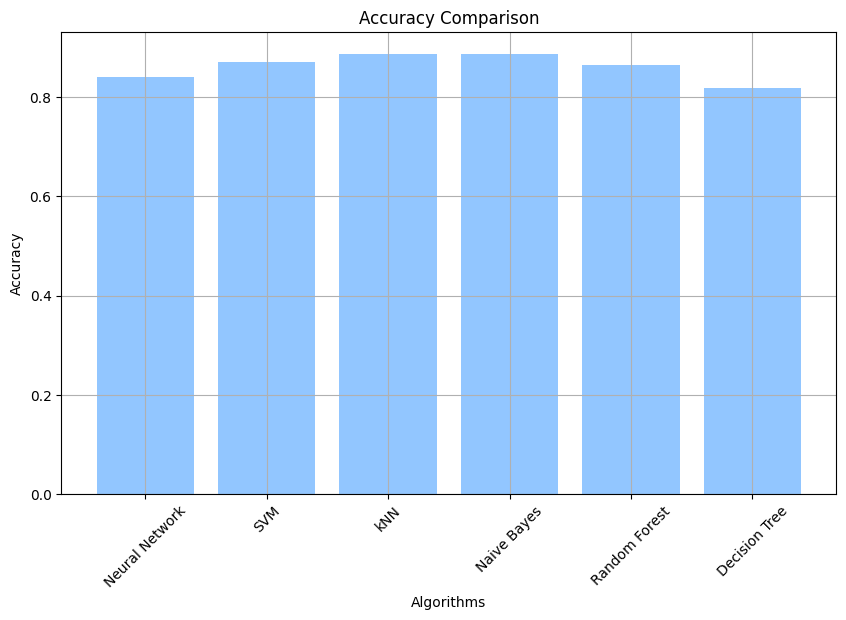

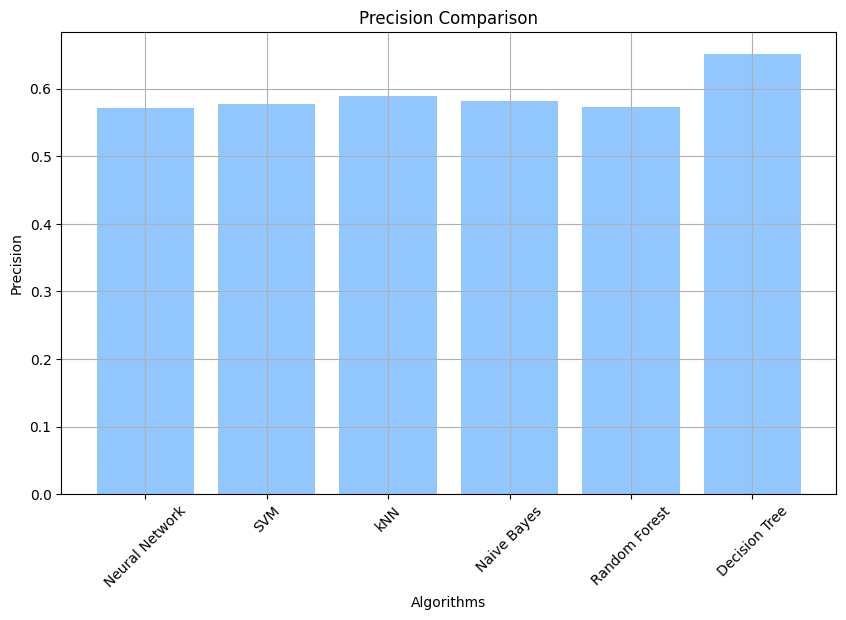

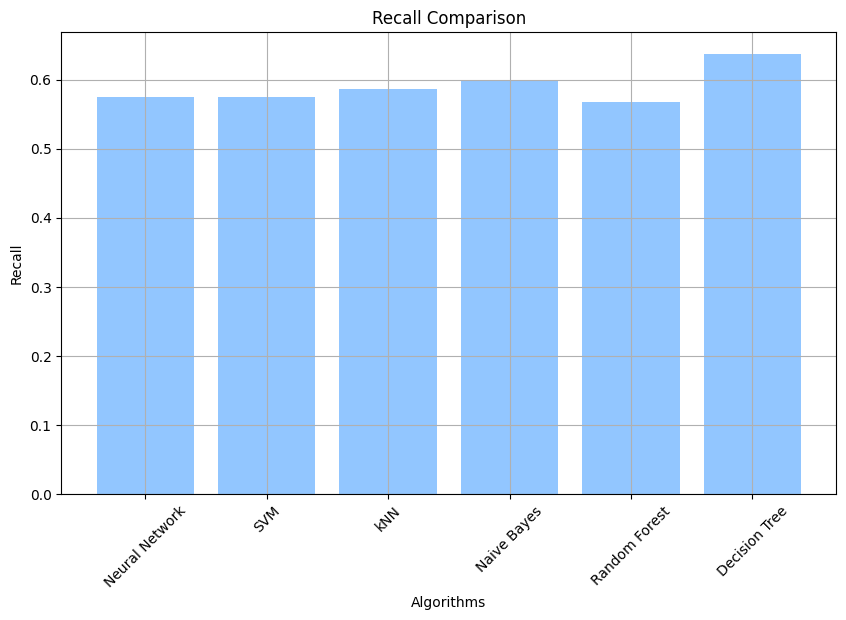

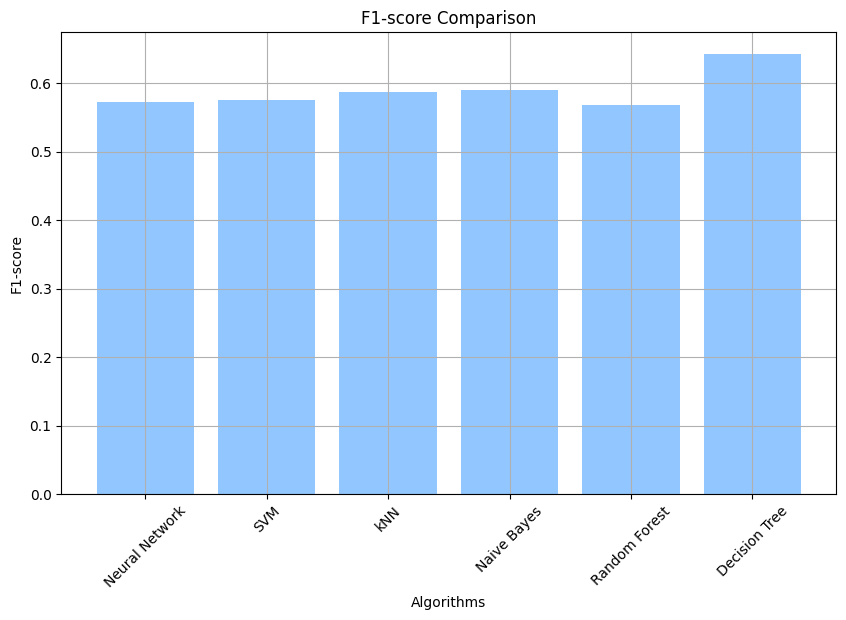

In [42]:
# Các thuật toán
algorithms = ['Neural Network', 'SVM', 'kNN', 'Naive Bayes', 'Random Forest', 'Decision Tree']

# Độ đo đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Giá trị đánh giá cho từng thuật toán và độ đo
accuracy_scores = [nn_accuracy, svm_accuracy, knn_accuracy, nb_accuracy, rf_accuracy, dt_accuracy]
precision_scores = [nn_precision, svm_precision, knn_precision, nb_precision, rf_precision, dt_precision]
recall_scores = [nn_recall, svm_recall, knn_recall, nb_recall, rf_recall, dt_recall]
f1_scores = [nn_f1score, svm_f1score, knn_f1score, nb_f1score, rf_f1score, dt_f1score]

# Vẽ biểu đồ cho từng độ đo đánh giá
for metric in metrics:
    scores = [accuracy_scores, precision_scores, recall_scores, f1_scores]
    index = metrics.index(metric)

    plt.figure(figsize=(10, 6))
    plt.bar(algorithms, scores[index])
    plt.xlabel('Algorithms')
    plt.ylabel(metric)
    plt.title(metric + ' Comparison')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()